In [1]:
import sys
import os
from datetime import datetime
from functools import cache
from itertools import groupby, chain
from pathlib import Path
from types import MethodType
from difflib import SequenceMatcher
import joblib
from tqdm.auto import tqdm

import numpy as np
import webvtt
from praatio import textgrid
import epitran
import panphon

In [2]:
def softmax(x):
    return np.exp(x)/np.exp(x).sum(axis=1)[:,np.newaxis]

In [3]:
@cache
def compute_phone_dist(tgt_phone):
    mask = np.array([x in ft.seg_dict for x in allo_ipas])
    if tgt_phone not in ft.seg_dict:
        dist_vec = np.ones((len(allo_ipas),))*15
    else:
        phone_dist = [ft.fts(tgt_phone).hamming_distance(ft.fts(allo_phone_x))
                          for allo_phone_x in allo_ipas
                          if allo_phone_x in ft.seg_dict]
        dist_vec = np.zeros((len(allo_ipas),))
        dist_vec[~mask] = np.max(phone_dist)+1
        dist_vec[mask] = phone_dist
    return dist_vec

In [4]:
def compute_scores(prob_mat, tgt_phone):
    dist_vec = compute_phone_dist(tgt_phone)
    dist_vec = np.exp(-dist_vec)    
    dist_vec /= np.sum(dist_vec)
    # logit_mat: M X V
    # dist_vec: V
    score_vec = prob_mat.dot(dist_vec)    
    Z = np.sum(score_vec)
    p_vec = score_vec/Z
    return p_vec

In [47]:
N

41

In [48]:
def compute_trellis(prob_mat, epi_phones, C_del=-np.log(0.01)):
    M, V = prob_mat.shape
    N = len(epi_phones)
    trellis = np.zeros((M, N))
    trellis[0,:] = np.arange(N)
    trellis[:,0] = np.arange(M)    
    backtrack = {(i, 0): ((i-1, 0),i) for i in range(1,M)}
    backtrack.update({(0,j): ((0,j-1),j) for j in range(1,N)})  #type:ignore
    for j in range(1,N):
        mu_j = -np.log(compute_scores(prob_mat, epi_phones[j]))
        for i in range(1,M):
            dist_vec = [
                # replace
                trellis[i-1, j-1] + mu_j[i],
                # delete (skip epi_phone)
                trellis[i, j-1] + C_del,
                # insert (stay at same epi_phone)
                trellis[i-1, j] + mu_j[i]
            ]
            dist_argmin = np.argmin(dist_vec)
            pointer = ((i-1,j-1),(i,j-1),(i-1,j))[dist_argmin]
            mindist_x = np.min(dist_vec)
            backtrack[i,j] = (pointer, mindist_x)        
            trellis[i,j] = mindist_x
    return trellis, backtrack
        

In [34]:
def create_path(init_point, backtrack):
    path = []    
    buf = [init_point]
    while buf:
        cur_point = buf.pop()
        path.append(cur_point)
        if cur_point in backtrack:
            prev_point = backtrack[cur_point][0]            
            buf.append(prev_point)            
    return path[::-1]            

In [35]:
def to_seconds(time_str):
    ref = datetime(1900,1,1)
    delta = datetime.strptime(time_str, "%H:%M:%S.%f")-ref
    return delta.seconds + delta.microseconds/1000000

In [36]:
#https://github.com/dmort27/epitran/blob/a30eef02327af0f5f1d161fa427f9e56545b3b64/epitran/epihan.py
def transliterate_char(self, text):
    tokens = self.cedict.tokenize(text)
    ipa_tokens = []
    for token in tokens:
        if token in self.cedict.hanzi:
            (pinyin, _) = self.cedict.hanzi[token]            
            ipa = [self.rules.apply(pinyin_x)
                   for pinyin_x in pinyin]
            ipa = [x.replace(u',', u'') for x in ipa]
            ipa_tokens.extend(ipa)
        else:
            ipa_tokens.append(token)
    return ipa_tokens

In [37]:
def extract_dark_phones(phone_logits):
    max_idxs = phone_logits.argsort()[::-1]
    if max_idxs[0] != 0:
        # return [ipa_tokens[i] for i in max_idxs[:1]]
        return None
    else:
        return allo_ipas[max_idxs[1]]

In [38]:
def align_phones(paths, epi_phones, frames):
    label_spans = groupby(paths, key=lambda x: x[1])
    aligned = []
    epi_idxs = []
    last_frame_i = -1
    for epi_id, paths_x in label_spans:
        epi_phone_x = epi_phones[epi_id]
        paths_x = list(paths_x)
        # print(label_id, paths_x)
        start_frame_i = paths_x[0][0]
        end_frame_i = paths_x[-1][0]

        if last_frame_i == start_frame_i:
            # skip duplicate frames, i.e. dropping labels
            aligned.append((epi_phone_x, [])) 
            epi_idxs.append(epi_id)
            continue
        else:
            aligned.append((epi_phone_x, 
                           frames[start_frame_i:end_frame_i+1]))        
            epi_idxs.append(epi_id)
        last_frame_i = start_frame_i
    return aligned

def align_characters(transcript, aligned_phones):        
    char_map = []
    cursor = 0
    for ch_idx, ch_ipas in enumerate(epi.transliterate_char(transcript)):
        char_phones_x = ft.ipa_segs(ch_ipas)        
        char_map.append(list(range(cursor, cursor+len(char_phones_x)+1)))
        cursor += len(char_phones_x)        
    
    print(char_map)
    aligned = []
    for char_i, phone_idxs in enumerate(char_map):             
        if not phone_idxs:
            continue
        first_phone_i = phone_idxs[0]
        last_phone_i = phone_idxs[-1]
        frames_x = [aligned_phones[i][1]
                    for i in range(first_phone_i, last_phone_i)]
        frames_x = sum(frames_x, [])        
        aligned.append((transcript[char_i], frames_x))
    return aligned

In [49]:
# EpiPhone = str
# Charac = str
# AlignedEntries = Tuple[EpiPhone|Charac, List[EmitFrame]]
# aligned_entries: List[AlignedPhone]
def make_aligned_textgrid(aligned_entries):        
    entries = []
    for label_x, frames_x in aligned_entries:                
        if not frames_x: continue
        start = frames_x[0].offset_s    
        end = frames_x[-1].end
        entries.append((start, end, label_x))        
    return entries

def make_raw_textgrid(frames):
    entries = []
    for i in range(len(frames)):
        start = frames[i].offset_s        
        end = frames[i].end   
        if frames[i].phone_token == "<blk>":
            phone_token = "[{}]".format(extract_dark_phones(frames[i].phone_logits))
        else:
            phone_token = frames[i].phone_token
        entries.append((start, end, phone_token))
    return entries


## Aligning

In [40]:
# globals
ipa_text_path = Path("../data/allosaurus_ipas.txt")
allo_ipas = ipa_text_path.read_text(encoding="UTF-8").split()
ft = panphon.FeatureTable()

In [41]:
epi = epitran.Epitran('cmn-Hant', cedict_file='../data/cedict_1_0_ts_utf-8_mdbg.txt')
emits = joblib.load("../data/emitframes_clgvd-210315091356.emit2.pkl")
ipa_text_path = Path("../data/allosaurus_ipas.txt")
vtt = webvtt.read("../data/clgvd-210315091356.wav.vtt")

epi.epi.transliterate_char = MethodType(transliterate_char, epi.epi)
epi.transliterate_char = epi.epi.transliterate_char

## Main loop

In [42]:
#　[i for i in range(len(vtt)) if "長這樣" in vtt[i].text]
print(vtt[161])

00:05:14.320 00:05:15.600 至少目前他們朝這方面在努力當中


In [43]:
# 387 還是因為我時間到
vtt_idx = 161

In [44]:
aligned_phones

[('a', [<EmitFrameInfo o @314.49>]),
 ('n', [<EmitFrameInfo ŋ @314.52>]),
 ('t͡s', [<EmitFrameInfo m @314.55>]),
 ('a', [<EmitFrameInfo <blk> @314.61>]),
 ('i', [<EmitFrameInfo t @314.70>, <EmitFrameInfo e @314.73>]),
 ('n', [<EmitFrameInfo <blk> @314.76>]),
 ('u', [<EmitFrameInfo l̪ @314.94>]),
 ('l', [<EmitFrameInfo l @314.97>]),
 ('i', [<EmitFrameInfo i @315.00>, <EmitFrameInfo <blk> @315.03>]),
 ('t', [<EmitFrameInfo t @315.06>]),
 ('a', [<EmitFrameInfo o @315.12>]),
 ('ŋ', [<EmitFrameInfo ŋ @315.15>]),
 ('ʈ͡ʂ', [<EmitFrameInfo <blk> @315.21>, <EmitFrameInfo t @315.24>]),
 ('o', [<EmitFrameInfo u @315.27>, <EmitFrameInfo o @315.30>]),
 ('ŋ', [<EmitFrameInfo ŋ @315.33>, <EmitFrameInfo <blk> @315.36>])]

In [50]:
vtt_x = vtt[vtt_idx]
vtt_start = to_seconds(vtt_x.start)
vtt_end = to_seconds(vtt_x.end)
transcript = vtt_x.text
frames = [x for x in emits
          if vtt_start < x.offset_s < vtt_end]

# set frame's `end` attribute for easier programming

for frame_i in range(0, len(frames)-1):
    setattr(frames[frame_i], "start", frames[frame_i].offset_s)
    setattr(frames[frame_i], "end", frames[frame_i+1].offset_s)
setattr(frames[0], "start", vtt_start)
setattr(frames[-1], "end", vtt_end)

# forced alignment
# logit_mat: M (# of tokens) x V (# of phone set)
logit_mat = np.vstack([x.phone_logits for x in frames])
prob_mat = softmax(logit_mat)
M, V = prob_mat.shape
epi_ipas = epi.transliterate(transcript)
epi_phones = ft.ipa_segs(epi_ipas)
N = len(epi_phones)
print(M, N, V)
trellis, backtrack = compute_trellis(prob_mat, epi_phones)

# trace paths
init_point = (logit_mat.shape[0]-1, len(epi_phones)-1)
paths = create_path(init_point, backtrack)
aligned_phones = align_phones(paths, epi_phones, frames)
aligned_chars = align_characters(transcript, aligned_phones)

# write textgrids
aligned_chars = make_aligned_textgrid(aligned_chars)
aligned_entries = make_aligned_textgrid(aligned_phones)
raw_entries = make_raw_textgrid(frames)
tg = textgrid.Textgrid()
minT = vtt_start
maxT = vtt_end
tg.addTier(textgrid.IntervalTier("characs", entryList=aligned_chars, minT=minT, maxT=maxT))
tg.addTier(textgrid.IntervalTier("phones", entryList=aligned_entries, minT=minT, maxT=maxT))
tg.addTier(textgrid.IntervalTier("alloframe", entryList=raw_entries, minT=minT, maxT=maxT))
tg.save(f"../data/allosaurus.align.{vtt_idx}.TextGrid", format="short_textgrid", includeBlankSpaces=False)

20 41 230
[[0, 1, 2], [2, 3, 4, 5], [5, 6, 7], [7, 8, 9, 10, 11], [11, 12, 13], [13, 14, 15, 16], [16, 17, 18, 19], [19, 20, 21], [21, 22, 23, 24], [24, 25, 26, 27, 28], [28, 29, 30, 31], [31, 32, 33], [33, 34, 35], [35, 36, 37, 38], [38, 39, 40, 41]]


In [52]:
paths

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (1, 27),
 (2, 28),
 (3, 29),
 (4, 30),
 (5, 30),
 (6, 31),
 (7, 32),
 (8, 33),
 (9, 34),
 (10, 34),
 (11, 35),
 (12, 36),
 (13, 37),
 (14, 38),
 (15, 38),
 (16, 39),
 (17, 39),
 (18, 40),
 (19, 40)]

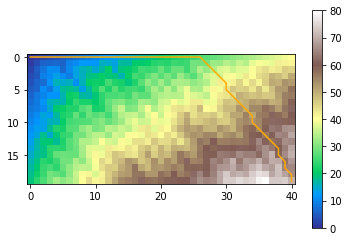

In [53]:
import matplotlib.pyplot as plt
plt.imshow(trellis, 'terrain')
plt.plot([j for (i,j) in paths], [i for (i,j) in paths], color='#FFAA00')
plt.colorbar()
# plt.axis('equal')


In [54]:
align_characters(transcript, aligned_phones)

[[0, 1, 2], [2, 3, 4, 5], [5, 6, 7], [7, 8, 9, 10, 11], [11, 12, 13], [13, 14, 15, 16], [16, 17, 18, 19], [19, 20, 21], [21, 22, 23, 24], [24, 25, 26, 27, 28], [28, 29, 30, 31], [31, 32, 33], [33, 34, 35], [35, 36, 37, 38], [38, 39, 40, 41]]


[('至', [<EmitFrameInfo o @314.49>]),
 ('少', []),
 ('目', []),
 ('前', []),
 ('他', []),
 ('們', []),
 ('朝', []),
 ('這', []),
 ('方', []),
 ('面', [<EmitFrameInfo ŋ @314.52>]),
 ('在',
  [<EmitFrameInfo m @314.55>,
   <EmitFrameInfo <blk> @314.61>,
   <EmitFrameInfo t @314.70>,
   <EmitFrameInfo e @314.73>]),
 ('努', [<EmitFrameInfo <blk> @314.76>, <EmitFrameInfo l̪ @314.94>]),
 ('力',
  [<EmitFrameInfo l @314.97>,
   <EmitFrameInfo i @315.00>,
   <EmitFrameInfo <blk> @315.03>]),
 ('當',
  [<EmitFrameInfo t @315.06>,
   <EmitFrameInfo o @315.12>,
   <EmitFrameInfo ŋ @315.15>]),
 ('中',
  [<EmitFrameInfo <blk> @315.21>,
   <EmitFrameInfo t @315.24>,
   <EmitFrameInfo u @315.27>,
   <EmitFrameInfo o @315.30>,
   <EmitFrameInfo ŋ @315.33>,
   <EmitFrameInfo <blk> @315.36>])]